### **IMPORT LIBRARIES**

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
import catboost as cat_
import seaborn as sns
import lightgbm as lgb

import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler
import random
warnings.filterwarnings("ignore")
warnings.simplefilter(action= 'ignore', category= FutureWarning)
pd.set_option('display.max_columns', 200)

### **HELPER FUNCTION**

This is where the cross validation loop and other processes are built for easy training and stacking throughout our workflow...  In this class, a variable "val_p" has been created. This is where all the predictions based on the validation set from each cross validation loop is stored, resulting to us having predictions based on the whole training data itself. Also, another 
variable "test_p" is where the test set predictions are stored.

In [7]:
class func() :   
    def __init__(self, train, label, test, model, model_type, random_state):
        self.train, self.label, self.test = train, label, test
        self.model, self.model_type = model, model_type
        self.random_state = random_state
        
        assert self.model_type in ('catboost', 'xgboost', 'lgbm'), 'Incorrect model_type'
    def __call__(self, plot = True):
        return self.fit(plot)

    def fit(self, plot):
        def catboost_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=500,
                           verbose=50,use_best_model=True)
            x_test_predict = self.model.predict_proba(X_test)[:,1]
            x_train_predict = self.model.predict_proba(X_train)[:,1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test)[:,1]
            return x_test_predict, x_train_predict

        def xgboost_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric="auc",
                           eval_set=[(X_test, y_test)], verbose = True)
            x_test_predict = self.model.predict_proba(X_test, ntree_limit = self.model.get_booster().best_ntree_limit)[:,1]
            x_train_predict = self.model.predict_proba(X_train, ntree_limit = self.model.get_booster().best_ntree_limit)[:,1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test, ntree_limit = self.model.get_booster().best_ntree_limit)[:,1]
            return x_test_predict, x_train_predict

        def lgbm_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric="auc",
                           eval_set=[(X_test, y_test)], verbose = True)
            x_test_predict = self.model.predict_proba(X_test, num_iteration = self.model.best_iteration_)[:,1]
            x_train_predict = self.model.predict_proba(X_train, num_iteration = self.model.best_iteration_)[:,1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test, num_iteration = self.model.best_iteration_)[:,1]
            return x_test_predict, x_train_predict


        self.val_p = np.zeros(self.train.shape[0])
        mean_val = []
        mean_train = []
        self.test_p = np.zeros(self.test.shape[0])
        splits = 5
        kf = StratifiedKFold(n_splits = splits)
        for fold_count, (train_index, test_index) in enumerate(kf.split(self.train, self.label)):
            X_train,X_test = self.train.iloc[train_index],self.train.iloc[test_index]
            y_train,y_test = self.label.iloc[train_index],self.label.iloc[test_index]

            print(f"================================Fold{fold_count+1}====================================")
            if self.model_type == 'catboost': x_test_predict, x_train_predict = catboost_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'xgboost': x_test_predict, x_train_predict = xgboost_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'lgbm': x_test_predict, x_train_predict = lgbm_fit(X_train, X_test, y_train, y_test)

            print('\nValidation scores', roc_auc_score(y_test, x_test_predict), log_loss(y_test, x_test_predict))
            print('Training scores', roc_auc_score(y_train, x_train_predict), log_loss(y_train, x_train_predict))
            mean_val.append(roc_auc_score(y_test, x_test_predict))
            mean_train.append(roc_auc_score(y_train, x_train_predict))

        if plot:
            feat_imp = pd.DataFrame(sorted(zip(self.model.feature_importances_,self.train.columns)), columns=['Value','Feature'])
            plt.figure(figsize=(30,25))
            sns.barplot(x="Value", y="Feature", data=feat_imp.sort_values(by="Value", ascending=False))
            plt.ylabel('Feature Importance Score')
            plt.show()
            
        print(np.mean(mean_val), np.mean(mean_train), np.std(mean_val))
        return self.val_p, self.test_p/splits, self.model

### **DATA IMPORT AND CLEANING**

In [2]:
path = 'C:/Users/Hp/Desktop/DNS ML Bootcamp/Bootcamp/'

train = pd.read_csv(path + 'Train.csv')
test = pd.read_csv(path + 'Test.csv')

sub = pd.read_csv(path + 'SampleSubmission.csv')

FileNotFoundError: [Errno 2] File C:/Users/Hp/Desktop/DNS ML Bootcamp/Bootcamp/Train.csv does not exist: 'C:/Users/Hp/Desktop/DNS ML Bootcamp/Bootcamp/Train.csv'

In [9]:
##Checkpoint
data1 = train.copy()
data2 = test.copy()

In [10]:
##To display entire dataset
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',  None)

In [11]:
##Mapping default status
train['default_status'] = train['default_status'].map({'no': 0, 'yes': 1})

In [12]:
##Joining Train and Test
ntrain = train.shape[0]
ntest = test.shape[0]
data = pd.concat((train, test)).reset_index(drop=True)

In [13]:
data.columns

Index([&#39;Applicant_ID&#39;, &#39;form_field1&#39;, &#39;form_field2&#39;, &#39;form_field3&#39;,
       &#39;form_field4&#39;, &#39;form_field5&#39;, &#39;form_field6&#39;, &#39;form_field7&#39;,
       &#39;form_field8&#39;, &#39;form_field9&#39;, &#39;form_field10&#39;, &#39;form_field11&#39;,
       &#39;form_field12&#39;, &#39;form_field13&#39;, &#39;form_field14&#39;, &#39;form_field15&#39;,
       &#39;form_field16&#39;, &#39;form_field17&#39;, &#39;form_field18&#39;, &#39;form_field19&#39;,
       &#39;form_field20&#39;, &#39;form_field21&#39;, &#39;form_field22&#39;, &#39;form_field23&#39;,
       &#39;form_field24&#39;, &#39;form_field25&#39;, &#39;form_field26&#39;, &#39;form_field27&#39;,
       &#39;form_field28&#39;, &#39;form_field29&#39;, &#39;form_field30&#39;, &#39;form_field31&#39;,
       &#39;form_field32&#39;, &#39;form_field33&#39;, &#39;form_field34&#39;, &#39;form_field35&#39;,
       &#39;form_field36&#39;, &#39;form_field37&#39;, &#39;form_field38&#39;, &#3

In [14]:
#Checkpoint
dataset = data.copy()

### **FEATURE ENGINEERING**

In [15]:
##Risk Score 
data['form_field1'].fillna(data['form_field1'].mean(), inplace = True)
data['form_field2'].fillna(0, inplace = True)                                
data['Risk_Score'] = data['form_field1'] * data['form_field2']

In [16]:
##Average Severity
for col in ['form_field3', 'form_field4', 'form_field5']:
    data[col].fillna(0, inplace = True)
data['AvgSeverity'] = (data['form_field3'] + data['form_field4'] + data['form_field5'])/3

In [17]:
##Average Credit Available
for col in ['form_field6', 'form_field7', 'form_field8', 'form_field9', 'form_field10']:
    data[col].fillna(0, inplace = True)
data['AvgCreditAvailable'] = (data['form_field6'] + data['form_field7'] + data['form_field8'] + data['form_field9'] + data['form_field10'])/5

In [18]:
##
for col in ['form_field11', 'form_field12', 'form_field13']:
    data[col].fillna(0, inplace = True)
    
for col in ['form_field14', 'form_field15']:
    data[col].fillna(data[col].mean(), inplace = True)

In [19]:
##Average Active Credit Cards and Lines
for col in ['form_field16', 'form_field17', 'form_field18', 'form_field19', 'form_field20']:
    data[col].fillna(0, inplace = True)

data['AvgActiveCreditCards'] = (data['form_field16'] + data['form_field17'] + data['form_field19'])/3

data['AvgActiveCreditLines'] = (data['form_field18'] + data['form_field20'])/2

In [20]:
##
for col in ['form_field21', 'form_field22', 'form_field23', 'form_field24']:
    data[col].fillna(0, inplace = True)
    
for col in ['form_field25', 'form_field26', 'form_field27']:
    data[col].fillna(data[col].mean(), inplace = True)

In [21]:
##Average Tenure
for col in ['form_field34', 'form_field35', 'form_field36', 'form_field37', 'form_field38', 'form_field39']:
    data[col].fillna(0, inplace = True)
    
for col in ['form_field28', 'form_field29', 'form_field30', 'form_field31', 'form_field32', 'form_field33']:
    data[col].fillna(data[col].mean(), inplace = True)

data['AvgTenureOnLoan'] = round((data['form_field30'] + data['form_field31'])/2)
data['AvgTenureOnActiveCard'] = round((data['form_field32'] + data['form_field33'])/2)

In [22]:
##Average Utilization of Loans
for col in ['form_field40', 'form_field41']:
    data[col].fillna(0, inplace = True)
data['AvgUtilization'] = (data['form_field40'] + data['form_field41'])/2

In [23]:
##
for col in ['form_field42', 'form_field43', 'form_field44', 'form_field45', 'form_field46', 'form_field48', 'form_field49', 'form_field50']:
    data[col].fillna(0, inplace = True)

data['form_field47'].fillna('charge', inplace = True)

##Average Loan with two payments missed
data['AvgLoanPaymentMissed'] = (data['form_field45'] + data['form_field46'])/2

In [24]:
data['form_field47'] = data['form_field47'].map({'charge':0, 'lending':1}).astype(np.float)

data['form_field14'] = data['form_field14'].astype(np.float)

data['form_field28'] = data['form_field28']*24.0

In [25]:
#drop useless (48 and 49 were undefined features)

data.drop(columns=['form_field48', 'form_field49'], inplace=True)


In [26]:
# grouped by formfield 47 

region = data.groupby('form_field47',).mean()
region.drop('default_status', 1, inplace = True)
cols = []
for i in region.columns:
    if i != 'form_field47':
        region[i+'_reg_mean_all'] = region[i]
        region.drop(i, 1, inplace = True)
        cols.append(i+'_reg_mean_all')

data = pd.merge(data, region, on='form_field47', how = 'left')
for col in cols: data[col+'_freq'] = data[col].map(data[col].value_counts().to_dict())/len(data)

In [27]:
# change all time features in days to years

for i in ['form_field25','form_field26','form_field27','form_field28', 'form_field29', 'form_field30', 'form_field31']:
    data[i] = data[i]/365
    

    

for i in ['form_field32', 'form_field33']:
    data[i] = data[i]/12

    
# multiply ass the percentage features by 100

for i in ['form_field21','form_field22','form_field23','form_field24', 'form_field40', 'form_field41']:
    data[i] = data[i] * 100

# this one  below did not improve the prediction so i discarded it
#data['max_amount'] = data['form_field44'] * data['form_field12']
#data['min_amount'] = data['form_field50'] * data['form_field12']

# this one below helped but i remove it sometimes(just trying many different rubbishes....lol) 
data['max/min_amount'] = data['form_field44'] / data['form_field50']

In [29]:
data.drop(['Applicant_ID'], axis =1, inplace = True)

In [24]:
data.head()

,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,form_field10,form_field11,form_field12,form_field13,form_field14,form_field15,form_field16,form_field17,form_field18,form_field19,form_field20,form_field21,form_field22,form_field23,form_field24,form_field25,form_field26,form_field27,form_field28,form_field29,form_field30,form_field31,form_field32,form_field33,form_field34,form_field35,form_field36,form_field37,form_field38,form_field39,form_field40,form_field41,form_field42,form_field43,form_field44,form_field45,form_field46,form_field47,form_field50,default_status,Risk_Score,AvgSeverity,AvgCreditAvailable,AvgActiveCreditCards,AvgActiveCreditLines,AvgTenureOnLoan,AvgTenureOnActiveCard,AvgUtilization,AvgLoanPaymentMissed,form_field1_reg_mean_all,form_field2_reg_mean_all,form_field3_reg_mean_all,form_field4_reg_mean_all,form_field5_reg_mean_all,form_field6_reg_mean_all,form_field7_reg_mean_all,form_field8_reg_mean_all,form_field9_reg_mean_all,form_field10_reg_mean_all,form_field11_reg_mean_all,form_field12_reg_mean_all,form_field13_reg_mean_all,form_field14_reg_mean_all,form_field15_reg_mean_all,form_field16_reg_mean_all,form_field17_reg_mean_all,form_field18_reg_mean_all,form_field19_reg_mean_all,form_field20_reg_mean_all,form_field21_reg_mean_all,form_field22_reg_mean_all,form_field23_reg_mean_all,form_field24_reg_mean_all,form_field25_reg_mean_all,form_field26_reg_mean_all,form_field27_reg_mean_all,form_field28_reg_mean_all,form_field29_reg_mean_all,form_field30_reg_mean_all,form_field31_reg_mean_all,form_field32_reg_mean_all,form_field33_reg_mean_all,form_field34_reg_mean_all,form_field35_reg_mean_all,form_field36_reg_mean_all,form_field37_reg_mean_all,form_field38_reg_mean_all,form_field39_reg_mean_all,form_field40_reg_mean_all,form_field41_reg_mean_all,form_field42_reg_mean_all,form_field43_reg_mean_all,form_field44_reg_mean_all,form_field45_reg_mean_all,form_field46_reg_mean_all,form_field50_reg_mean_all,Risk_Score_reg_mean_all,AvgSeverity_reg_mean_all,AvgCreditAvailable_reg_mean_all,AvgActiveCreditCards_reg_mean_all,AvgActiveCreditLines_reg_mean_all,AvgTenureOnLoan_reg_mean_all,AvgTenureOnActiveCard_reg_mean_all,AvgUtilization_reg_mean_all,AvgLoanPaymentMissed_reg_mean_all,form_field1_reg_mean_all_freq,form_field2_reg_mean_all_freq,form_field3_reg_mean_all_freq,form_field4_reg_mean_all_freq,form_field5_reg_mean_all_freq,form_field6_reg_mean_all_freq,form_field7_reg_mean_all_freq,form_field8_reg_mean_all_freq,form_field9_reg_mean_all_freq,form_field10_reg_mean_all_freq,form_field11_reg_mean_all_freq,form_field12_reg_mean_all_freq,form_field13_reg_mean_all_freq,form_field14_reg_mean_all_freq,form_field15_reg_mean_all_freq,form_field16_reg_mean_all_freq,form_field17_reg_mean_all_freq,form_field18_reg_mean_all_freq,form_field19_reg_mean_all_freq,form_field20_reg_mean_all_freq,form_field21_reg_mean_all_freq,form_field22_reg_mean_all_freq,form_field23_reg_mean_all_freq,form_field24_reg_mean_all_freq,form_field25_reg_mean_all_freq,form_field26_reg_mean_all_freq,form_field27_reg_mean_all_freq,form_field28_reg_mean_all_freq,form_field29_reg_mean_all_freq,form_field30_reg_mean_all_freq,form_field31_reg_mean_all_freq,form_field32_reg_mean_all_freq,form_field33_reg_mean_all_freq,form_field34_reg_mean_all_freq,form_field35_reg_mean_all_freq,form_field36_reg_mean_all_freq,form_field37_reg_mean_all_freq,form_field38_reg_mean_all_freq,form_field39_reg_mean_all_freq,form_field40_reg_mean_all_freq,form_field41_reg_mean_all_freq,form_field42_reg_mean_all_freq,form_field43_reg_mean_all_freq,form_field44_reg_mean_all_freq,form_field45_reg_mean_all_freq,form_field46_reg_mean_all_freq,form_field50_reg_mean_all_freq,Risk_Score_reg_mean_all_freq,AvgSeverity_reg_mean_all_freq,AvgCreditAvailable_reg_mean_all_freq,AvgActiveCreditCards_reg_mean_all_freq,AvgActiveCreditLines_reg_mean_all_freq,AvgTenureOnLoan_reg_mean_all_freq,AvgTenureOnActiveCard_reg_mean_all_freq,AvgUtilization_reg_mean_all

Extract training data, test data and target

In [25]:
train = data[:ntrain].copy()
#train.drop_duplicates(inplace = True, ignore_index=True)
target = train.default_status.copy()
train.drop('default_status', axis=1, inplace=True)

test = data[ntrain:].copy()
test.drop('default_status', axis=1, inplace=True)
test = test.reset_index(drop=True)

In [26]:
test.columns.sort_values()

Index(['AvgActiveCreditCards', 'AvgActiveCreditCards_reg_mean_all',
       'AvgActiveCreditCards_reg_mean_all_freq', 'AvgActiveCreditLines',
       'AvgActiveCreditLines_reg_mean_all',
       'AvgActiveCreditLines_reg_mean_all_freq', 'AvgCreditAvailable',
       'AvgCreditAvailable_reg_mean_all',
       'AvgCreditAvailable_reg_mean_all_freq', 'AvgLoanPaymentMissed',
       ...
       'form_field7', 'form_field7_reg_mean_all',
       'form_field7_reg_mean_all_freq', 'form_field8',
       'form_field8_reg_mean_all', 'form_field8_reg_mean_all_freq',
       'form_field9', 'form_field9_reg_mean_all',
       'form_field9_reg_mean_all_freq', 'max/min_amount'],
      dtype='object', length=170)

### **MODEL 1 - CATBOOST**

================================Fold1====================================
0:	test: 0.7919472	best: 0.7919472 (0)	total: 512ms	remaining: 1h 25m 19s
50:	test: 0.8280048	best: 0.8280048 (50)	total: 9.69s	remaining: 31m 31s
100:	test: 0.8319528	best: 0.8319572 (99)	total: 18.1s	remaining: 29m 37s
150:	test: 0.8339268	best: 0.8339268 (150)	total: 26.1s	remaining: 28m 22s
200:	test: 0.8351691	best: 0.8351691 (200)	total: 34.5s	remaining: 28m 3s
250:	test: 0.8361501	best: 0.8361501 (250)	total: 43s	remaining: 27m 48s
300:	test: 0.8368215	best: 0.8368369 (299)	total: 51.3s	remaining: 27m 34s
350:	test: 0.8374668	best: 0.8374668 (350)	total: 59.3s	remaining: 27m 9s
400:	test: 0.8378903	best: 0.8378903 (400)	total: 1m 6s	remaining: 26m 30s
450:	test: 0.8382280	best: 0.8382280 (450)	total: 1m 11s	remaining: 25m 11s
500:	test: 0.8384576	best: 0.8384577 (499)	total: 1m 16s	remaining: 24m 8s
550:	test: 0.8386040	best: 0.8386161 (549)	total: 1m 21s	remaining: 23m 17s
600:	test: 0.8387651	best: 0.838

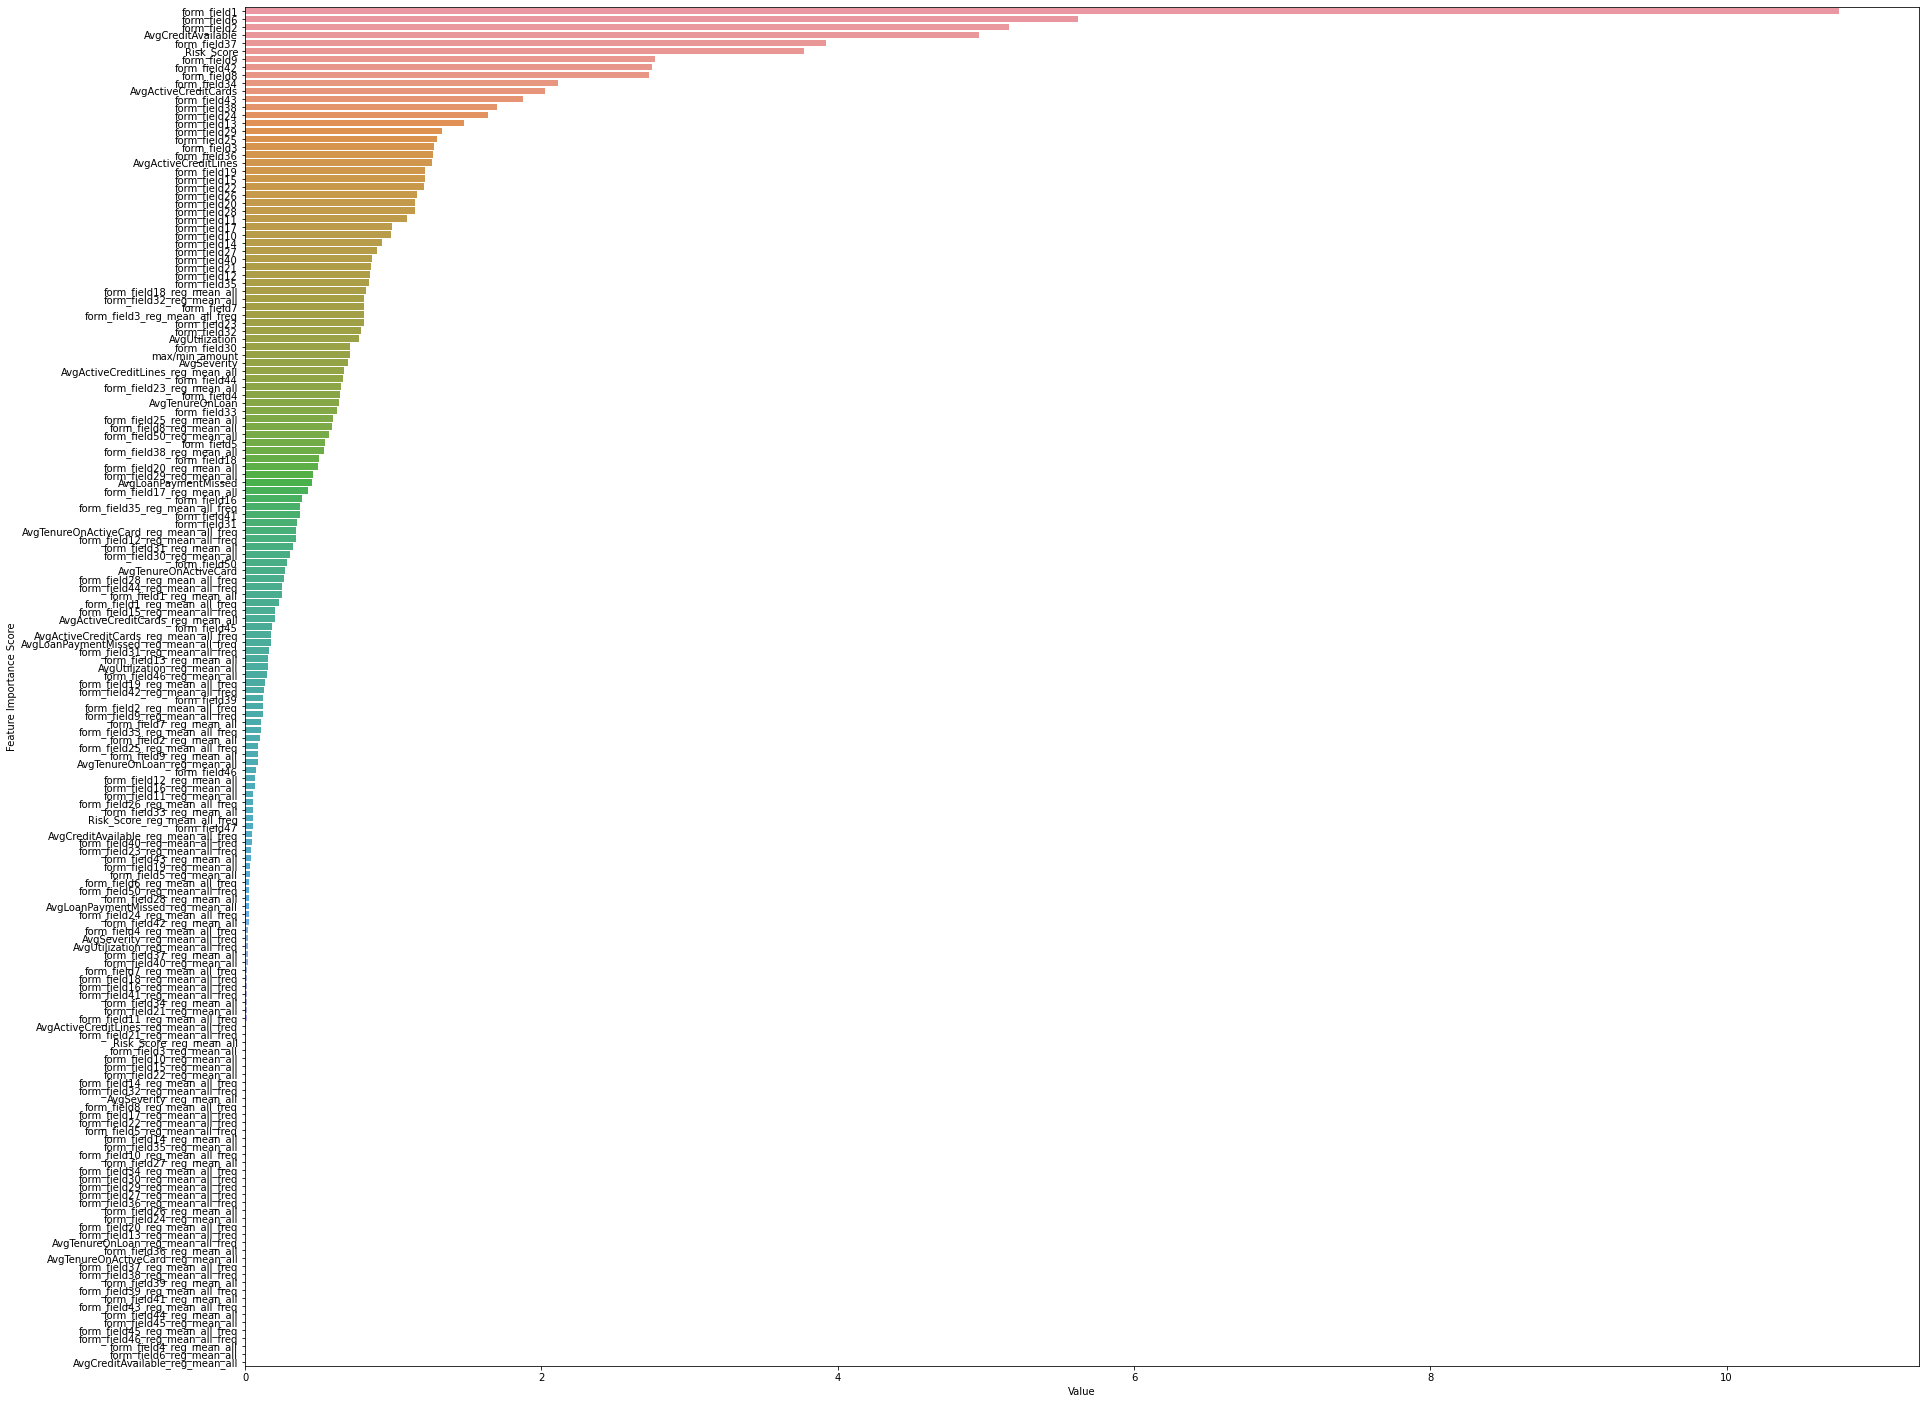

0.8403672439388107 0.8661366301123768 0.005948891685061243


In [27]:
catboost = cat_.CatBoostClassifier(n_estimators=10000, max_depth=6, eval_metric='AUC', reg_lambda = 370)#, task_type="GPU", devices='0:1')

func_= func(train, target, test, catboost, 'catboost', 1000)
val_p1, test_p1, model1 = func_()

### **MODEL 2 - XGBOOST**

To train on CPU, you would have to remove the **tree_method** and **gpu_id** parameters.

================================Fold1====================================
[22:49:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.76141
Will train until validation_0-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.79827
[2]	validation_0-auc:0.81240
[3]	validation_0-auc:0.81794
[4]	validation_0-auc:0.82158
[5]	validation_0-auc:0.82335
[6]	validation_0-auc:0.82541
[7]	validation_0-auc:0.82611
[8]	validation_0-auc:0.82716
[9]	validation_0-auc:0.82809
[10]	validation_0-auc:0.82882
[11]	validation_0-auc:0.82886
[12]	validation_0-auc:0.82994
[13]	validation_0-auc:0.83058
[14]	validation_0-auc:0.83048
[15]	validation_0-auc:0.83027
[16]

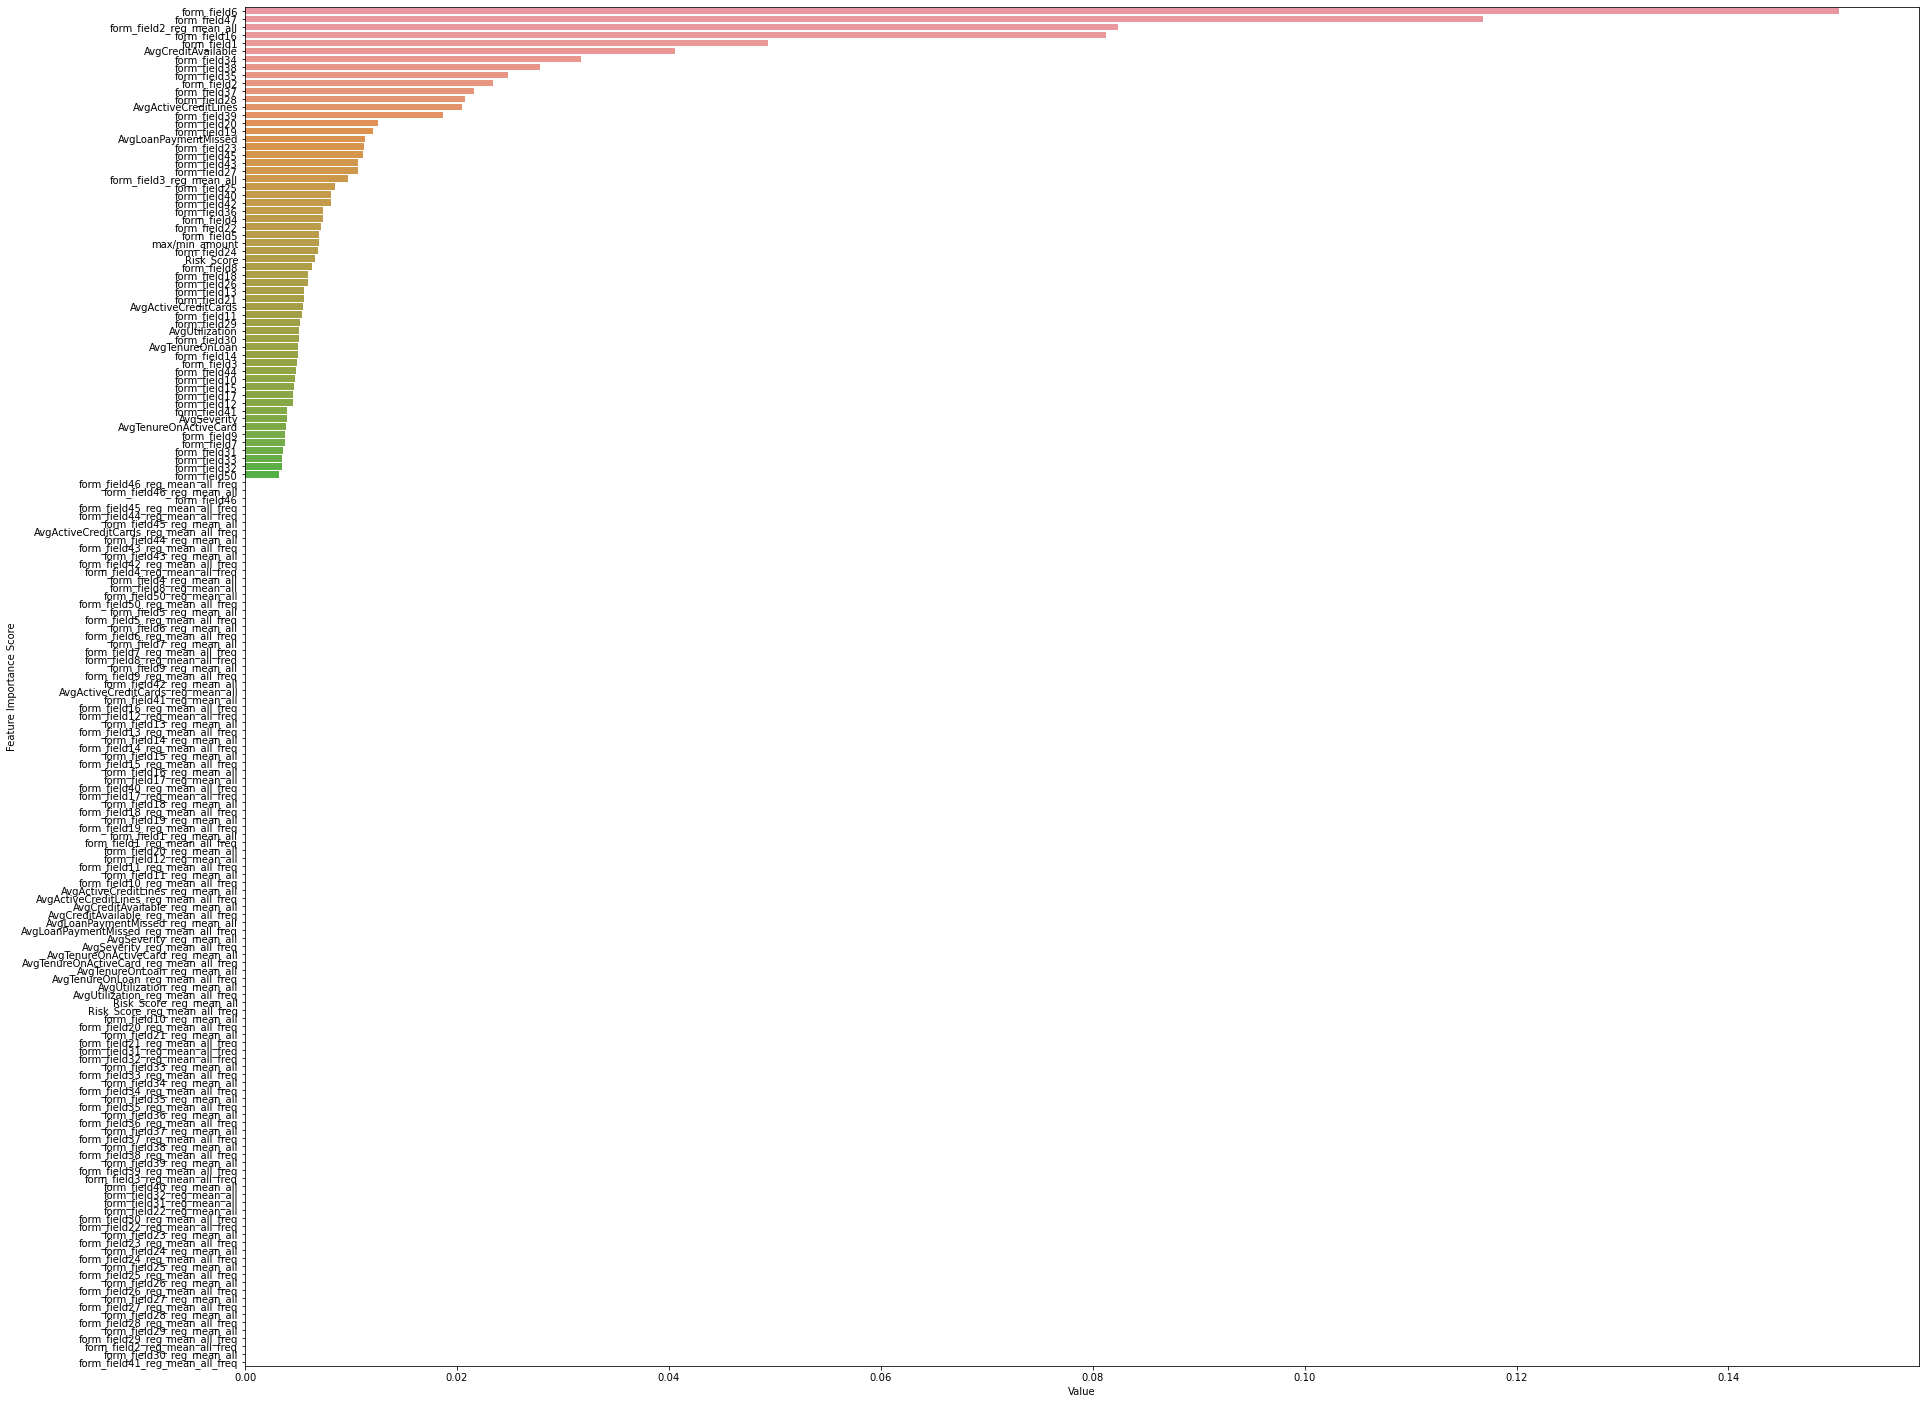

0.8309411799547288 0.8639721152569079 0.00510488987462021


In [28]:
xgboost = xgb.XGBClassifier(objective ='binary:logistic', 
                          eta = 0.99,
                          max_depth = 6, 
                          n_estimators = 5000,
                          reg_lambda = 500,
                          sub_sample = 0.8,
                          colsample_bytree = 0.8) #, tree_method='gpu_hist') #, gpu_id=0)

func_= func(train, target, test, xgboost, 'xgboost', 1000)
val_p2, test_p2, model2 = func_()

### **MODEL 3 - LGBM**

In [ ]:
import lightgbm as lgb
lgb_model = lgb.LGBMClassifier(objective =  'binary', 
                            metric= 'auc',
                            boosting_type= 'gbdt',
                            lambda_l1= 0.0004912993970392775,
                            lambda_l2= 9.424350138808432,
                            num_leaves= 24,
                            feature_fraction= 1.0,
                            bagging_fraction= 0.9540416539312312,
                            bagging_freq= 7,
                            min_child_samples= 100, n_estimators = 300)

func_= func(train, target, test, lgb_model, 'lgbm', 1000)
val_p3, test_p3, model3 = func_()

================================Fold1====================================
[1]	valid_0's auc: 0.802062
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.807149
[3]	valid_0's auc: 0.811849
[4]	valid_0's auc: 0.812329
[5]	valid_0's auc: 0.815578
[6]	valid_0's auc: 0.816808
[7]	valid_0's auc: 0.81788
[8]	valid_0's auc: 0.820108
[9]	valid_0's auc: 0.821182
[10]	valid_0's auc: 0.822197
[11]	valid_0's auc: 0.823782
[12]	valid_0's auc: 0.824612
[13]	valid_0's auc: 0.825428
[14]	valid_0's auc: 0.826073
[15]	valid_0's auc: 0.826739
[16]	valid_0's auc: 0.827257
[17]	valid_0's auc: 0.827826
[18]	valid_0's auc: 0.828435
[19]	valid_0's auc: 0.828855
[20]	valid_0's auc: 0.829267
[21]	valid_0's auc: 0.829643
[22]	valid_0's auc: 0.830141
[23]	valid_0's auc: 0.830642
[24]	valid_0's auc: 0.830897
[25]	valid_0's auc: 0.831039
[26]	valid_0's auc: 0.831342
[27]	valid_0's auc: 0.831434
[28]	valid_0's auc: 0.831754
[29]	valid_0's auc: 0.832219
[30]	valid_0's auc: 0.832509
[31]	

In [ ]:
# prediction based on grouping by formfield 47

test1_cat1 = test_p1
test1_xg1 = test_p2
test1_lgbm1 = test_p3

val1_cat1 = val_p1
val1_xg1 = val_p2
val1_lgbm1 = val_p3

model1_cat1 = model1
model1_xg1 = model2
model1_lgbm1 = model3


### **STACKING**

In [ ]:
# stacking based on line of best fit between the three models

from sklearn.linear_model import  LinearRegression, Ridge, Lasso
stack = np.column_stack((val_p1, val_p2, val_p3))
stack_p = np.column_stack((test_p1, test_p2, test_p3))
predict = LinearRegression().fit(stack, target).predict(stack_p)

In [ ]:
roc_auc_score(target, LinearRegression().fit(stack, target).predict(stack))

In [ ]:
prediction = ((test1_cat1 * 0.375) + (test1_xg1 * 0.285) + (test1_lgbm1 * 0.350))

### **SUBMISSION**

In [ ]:
sub['default_status'] = predict

In [ ]:
##Saving the prediction

sub.to_csv(path + 'my_prediction5.csv', index = False)

In [ ]:
sub['default_status'] = prediction
##Saving the prediction

sub.to_csv(path + 'my_prediction6.csv', index = False)